# PatchCore Example

#### Import dependencies

In [18]:
import image_anomaly_detection as iad

import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# 

## Training

#### Load dataset

In [19]:
data_path = '../../data/mvtec_dataset/bottle/train/good/' 
dataset = iad.IADataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [20]:
patch_core = iad.PatchCore()

#### Fit the model to the dataset

In [21]:
patch_core.fit(dataloader)

Feature extraction: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Getting transformed features...
Calculating distances...
Maximum distance from cluster centers is 2.09


#### Save the necessary parameters

In [22]:
distributions_path = '../distributions/'
torch.save(patch_core.embedding_coreset, distributions_path+'bottle_embedding_coreset.pt')

# 

## Inference
#### Load test images

In [23]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
batch = iad.to_batch(images, iad.standard_image_transform, torch.device('cpu'))

#### Load the necessary parameters

In [24]:
distributions_path = '../distributions/'
embedding_coreset = torch.load(distributions_path+'bottle_embedding_coreset.pt')

#### init the model

In [25]:
patch_core = iad.PatchCore('resnet18', embedding_coreset=embedding_coreset)

#### Make prediction

In [26]:
image_scores, score_map = patch_core.predict(batch)

#### Interpret the prediction

In [27]:
image_scores

tensor([3.1275, 2.4352, 2.7914, 1.7303, 1.7978])

In [28]:
# patch_scores_blurred = torchvision.transforms.GaussianBlur(7, sigma=2)(patch_scores)

In [29]:
THRESH = 2.0
patch_classifications = iad.patch_classification(score_map, THRESH)
image_classifications = iad.image_classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([3.1275, 2.4352, 2.7914, 1.7303, 1.7978])
Image classifications: tensor([0., 0., 0., 1., 1.])


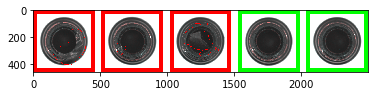

In [30]:
img = iad.boundary_image_classification_group(images, patch_classifications, image_classifications, 400)
plt.imshow(img)
plt.show()

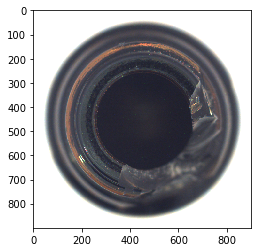

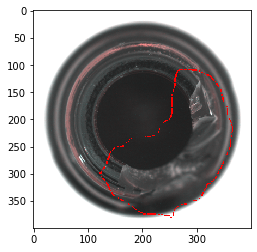

In [31]:
idx = 0
img = iad.boundary_image(images[idx], patch_classifications[idx], 400)
plt.imshow(images[idx])
plt.show()
plt.imshow(img)
plt.show()